In [1]:
from utils import *
from plotting import create_plot

In [2]:
top5 = pd.read_csv("../data/output_matching/matchms/matchms_tol_0.01_1%I_top5_with_0s.tsv", sep='\t')
#top5 = pd.read_csv("../data/output_matching/matchms/matchms_tol_0.01_1%I_all_peaks_with_0s.tsv", sep='\t')

In [3]:

#top5 = pd.read_csv("../data/output_matching/matchms/matchms_tol_0.01_1%I_all_peaks_with_0s.tsv", sep='\t')
top5_same = get_matching_rows(top5, 'query', 'reference')
merged_top5_same = normalize_df(append_classes(top5_same, 'query'), matches_norm_col=None)

merged_top5_same_N = merged_top5_same.copy()

# exclude nitrigen
merged_top5_same = merged_top5_same[merged_top5_same['N'] != True]

# Apply the function to each row of the DataFrame
merged_top5_same_N['true_names'] = merged_top5_same_N.apply(lambda row: get_true_names(row, merged_top5_same_N), axis=1)
merged_top5_same['true_names'] = merged_top5_same.apply(lambda row: get_true_names(row, merged_top5_same), axis=1)

# Convert the list of names to a comma-separated string
merged_top5_same_N['true_names'] = merged_top5_same_N['true_names'].apply(lambda lst: ', '.join(lst))
merged_top5_same['true_names'] = merged_top5_same['true_names'].apply(lambda lst: ', '.join(lst))

In [4]:
mdf = preprocess_data(merged_top5_same, ["true_names"])
mdf_N = preprocess_data(merged_top5_same_N, ["true_names"])

In [5]:
mdf = clean_chemical_composition_data(mdf)
mdf_N = clean_chemical_composition_data(mdf_N)

/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

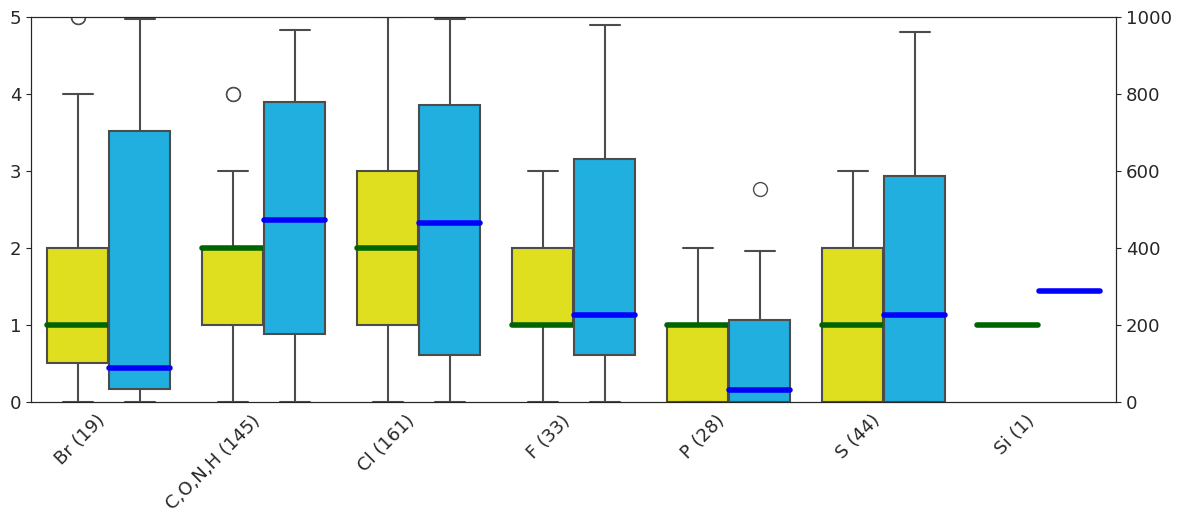

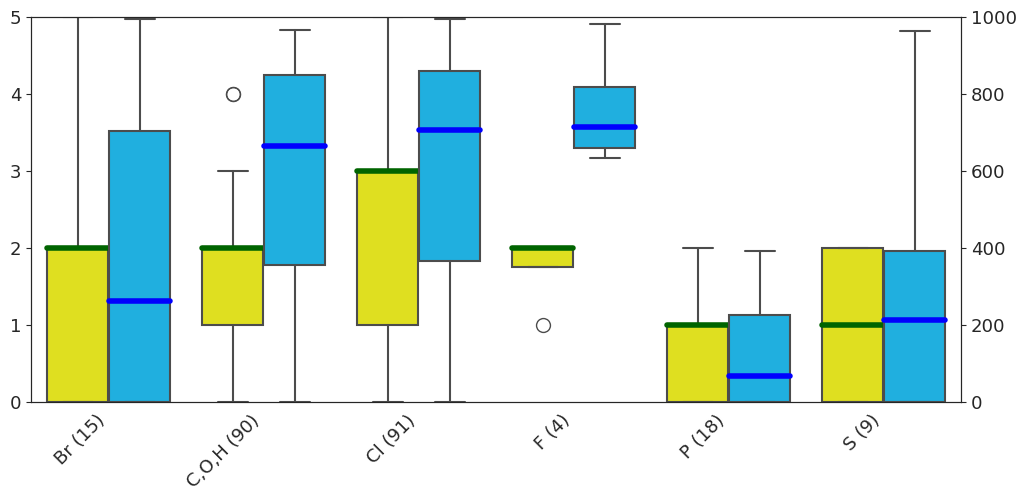

In [6]:
# with Nitrogen plot 1
mdf_N_p1 = split_and_add_rows(mdf_N, 'true_names', split_by=', ')
mdf_N_p1 = mdf_N_p1.sort_values(by=['true_names'])

create_plot(mdf_N_p1, "true_names", None, normalized_matches=False, hide_labels=True, showlegend=False).show()

# without Nitrogen plot 1
mdf_p1 = split_and_add_rows(mdf, 'true_names', split_by=', ')
mdf_p1 = mdf_p1.sort_values(by=['true_names'])
mdf_p1['true_names'].replace(to_replace="C,O,N,H", value="C,O,H", inplace=True)

create_plot(mdf_p1, "true_names", None, normalized_matches=False, hide_labels=True, showlegend=False).show()

In [ ]:
all_peaks = pd.read_csv("../data/output_matching/matchms/matchms_tol_0.01_1%I_all_peaks_with_0s.tsv", sep='\t')
all_peaks_same = get_matching_rows(all_peaks, 'query', 'reference')
merged_all_peaks_same = normalize_df(append_classes(all_peaks_same, 'query'), matches_norm_col=None)

/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

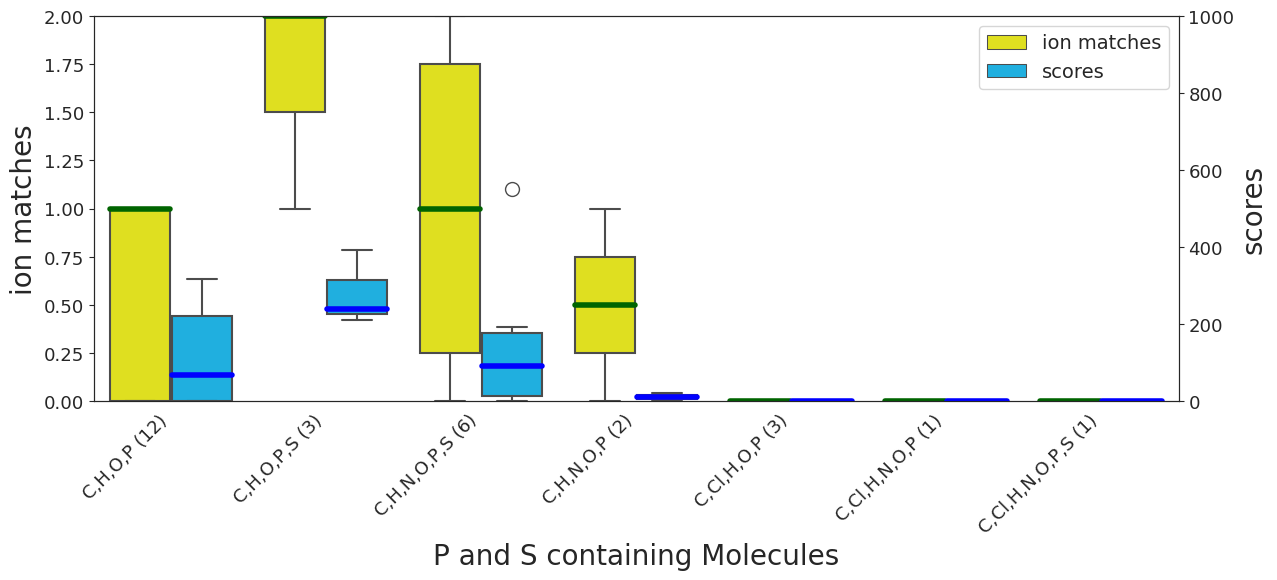

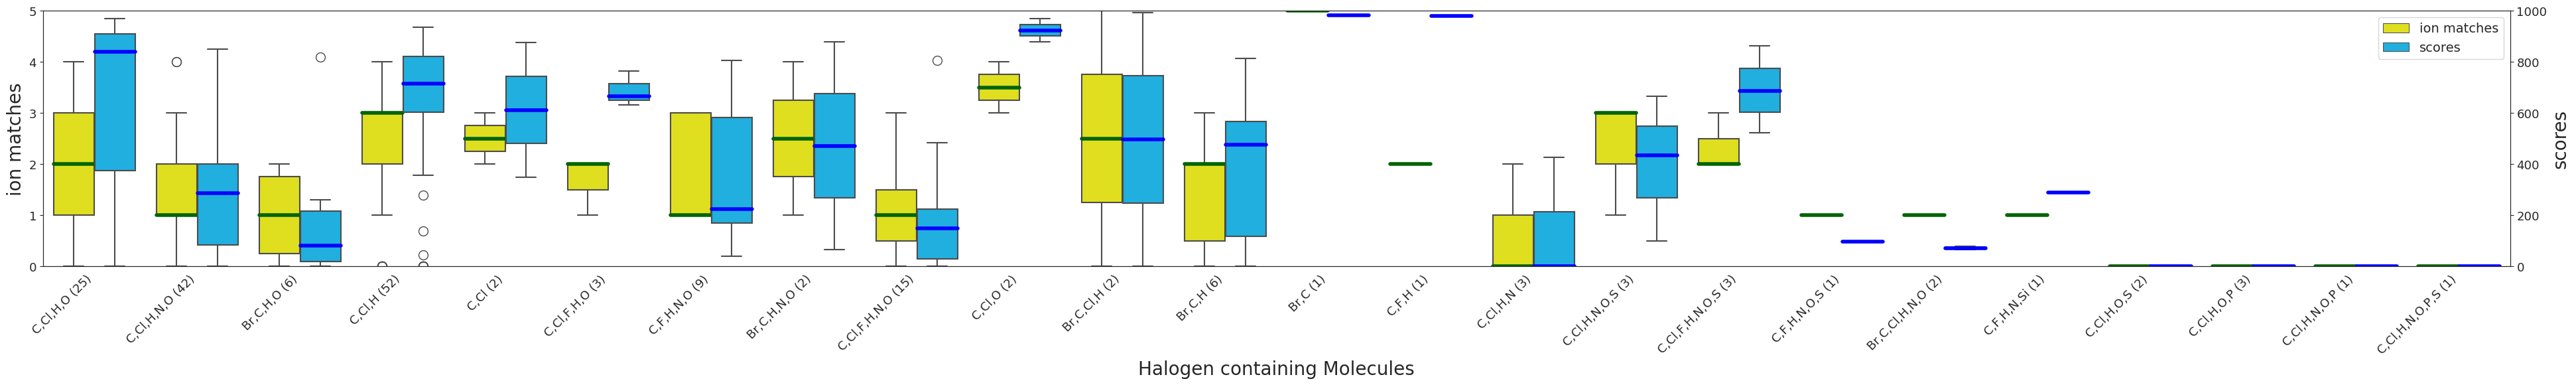

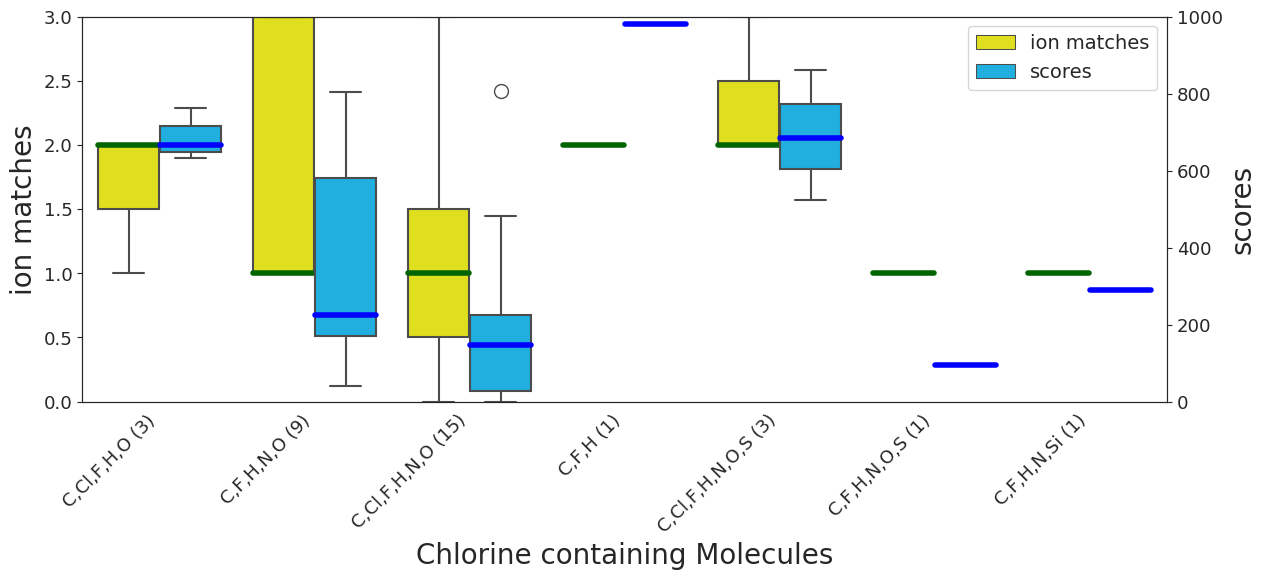

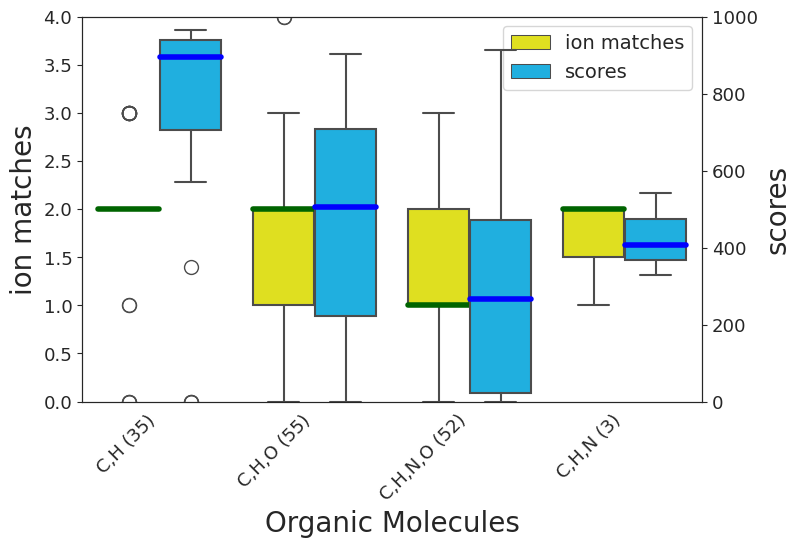

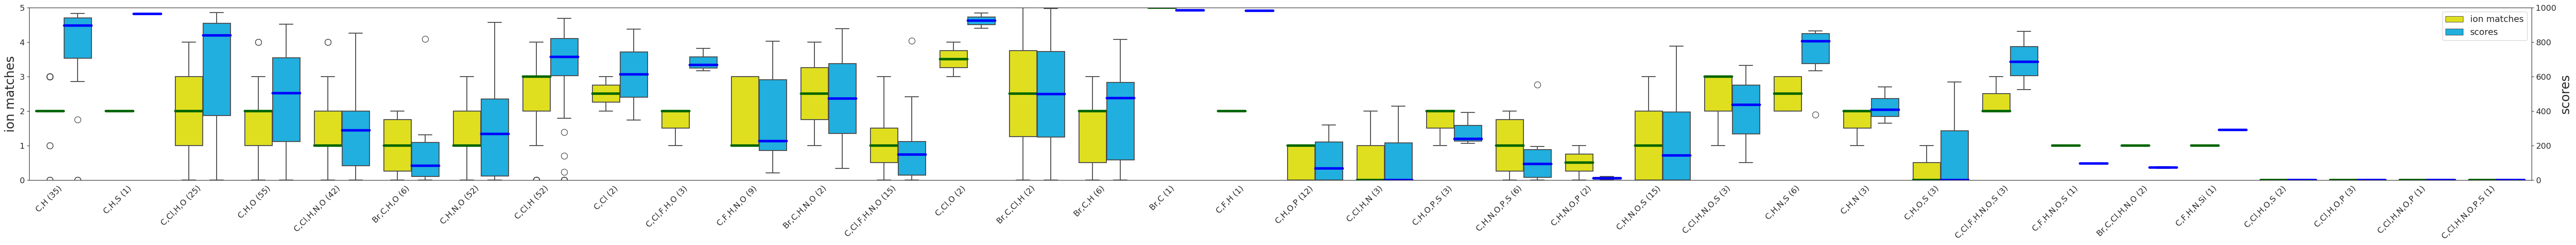

In [56]:
mdf_comp = preprocess_data(merged_top5_same_N, ["composition"])

mdf_comp_ps = mdf_comp[mdf_comp['composition'].str.contains('P|S and not Si')]
mdf_comp_halogen = mdf_comp[mdf_comp['composition'].str.contains('Cl|Br|F|I')]
mdf_comp_chlorinated = mdf_comp[mdf_comp['composition'].str.contains('Cl and not Br|F|I')]
mdf_comp_organic = mdf_comp.loc[mdf_comp['composition'].isin(['C,H', 'C,H,O', 'C,H,N', 'C,H,N,O'])]

create_plot(mdf_comp_ps, "composition", "P and S containing Molecules", normalized_matches=False).show()
create_plot(mdf_comp_halogen, "composition", "Halogen containing Molecules", normalized_matches=False).show()
create_plot(mdf_comp_chlorinated, "composition", "Chlorine containing Molecules", normalized_matches=False).show()
create_plot(mdf_comp_organic, "composition", "Organic Molecules", normalized_matches=False).show()
create_plot(mdf_comp, "composition", normalized_matches=False).show()

/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

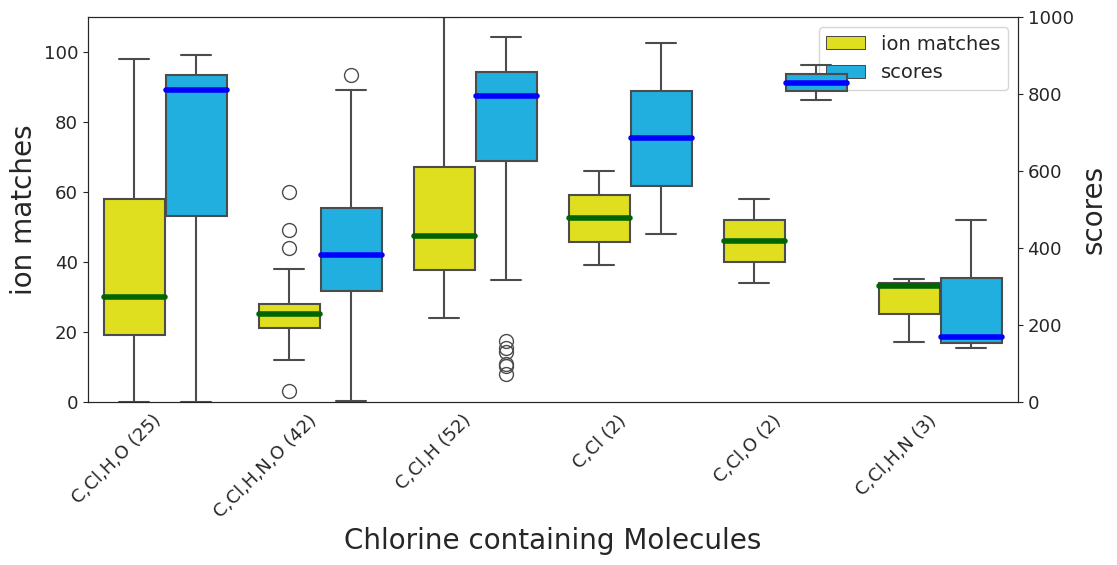

In [54]:
mdf_comp_chlorinated = mdf_comp[mdf_comp['composition'].str.contains('Cl') & ~mdf_comp['composition'].str.contains('Br|F|I|P|S|Si')]
create_plot(mdf_comp_chlorinated, "composition", "Chlorine containing Molecules", normalized_matches=False).show()

/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

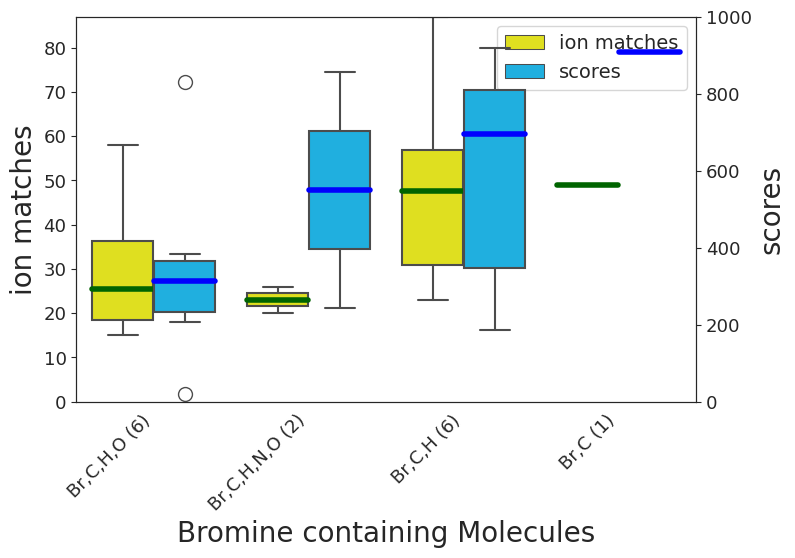

In [55]:
mdf_comp_brominated = mdf_comp[mdf_comp['composition'].str.contains('Br') & ~mdf_comp['composition'].str.contains('Cl|F|I|P|S|Si')]
create_plot(mdf_comp_brominated, "composition", "Bromine containing Molecules", normalized_matches=False).show()

/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

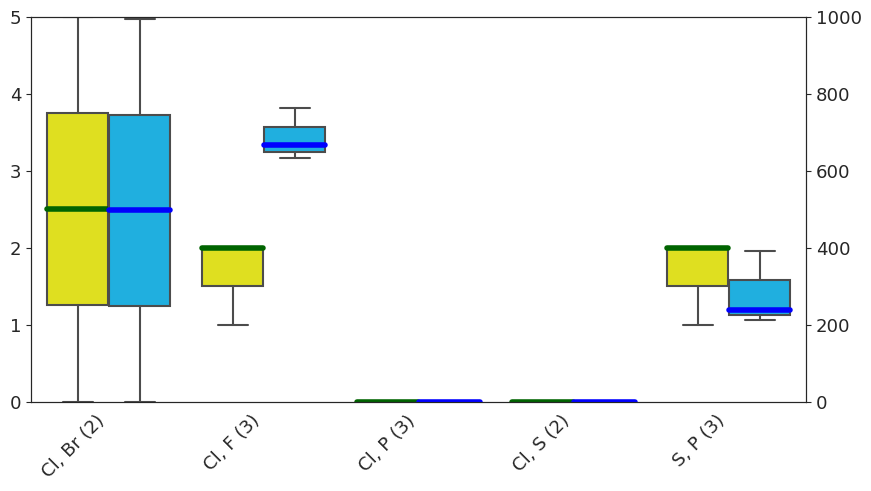

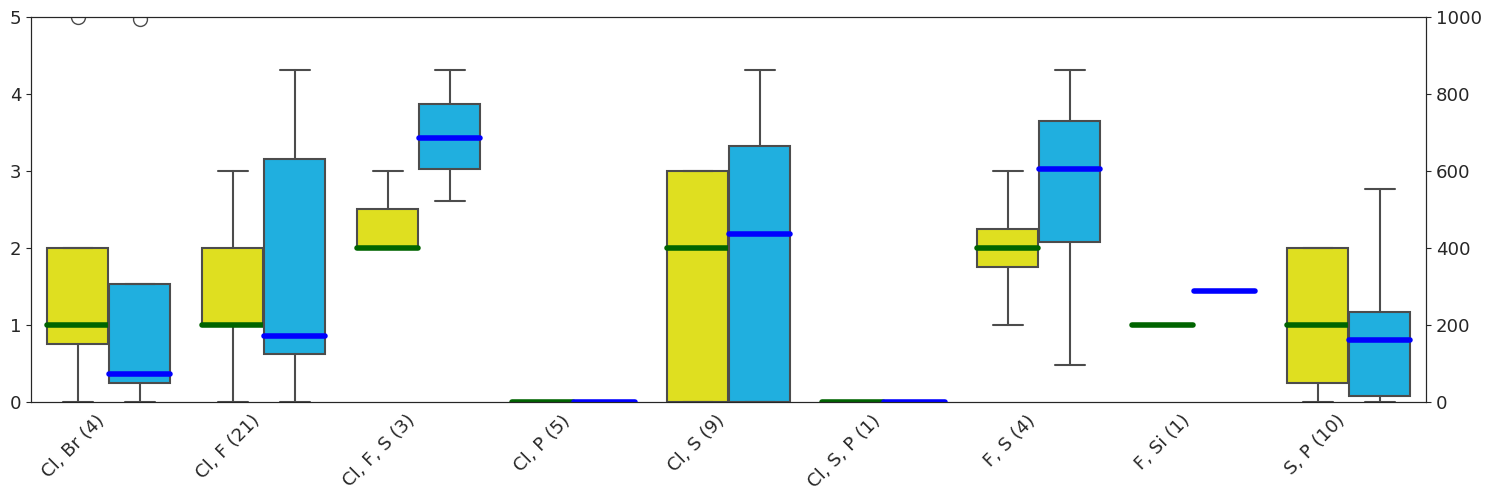

In [7]:
# without Nitrogen plot 2
mdf_p2 = generate_combinations(mdf, 'true_names')
mdf_p2 = mdf_p2.sort_values(by=['true_names'])

create_plot(mdf_p2, "true_names", None, normalized_matches=None, nist_scale=True, hide_labels=True, showlegend=False).show()

# with Nitrogen plot 2
mdf_N_p2 = generate_combinations(mdf_N, 'true_names')
mdf_N_p2 = mdf_N_p2.sort_values(by=['true_names'])

create_plot(mdf_N_p2, "true_names", None, normalized_matches=None, nist_scale=True, hide_labels=True, showlegend=False).show()